In [ ]:
import polars as pl
import polars.selectors as cs
import soccerdata as sd
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
import numpy as np
import pyarrow
import seaborn as sb
import bs4
import plotly.express as px
import math
import json
import os
import requests
from fontTools.misc.cython import returns
from mplsoccer import Pitch, FontManager, Sbopen, VerticalPitch

In [ ]:
# fm = sd.FotMob(leagues="ENG-Premier League", seasons="2025/2026")
ws = sd.WhoScored(leagues="ENG-Premier League", seasons=2025)
#match_stats = fm.read_team_match_stats(opponent_stats=True, team="Manchester United")
game_id = 1903338
game = ws.read_events(match_id=game_id)
loader = ws.read_events(game_id, output_fmt="loader")
df_players = loader.players(game_id=game_id)
game

In [3]:
from pyfonts import load_google_font
font = load_google_font("DotGothic16")

#パスネットワーク構築用function

In [16]:
def find_opp(df):
    teams = df['team'].sort_values().to_list()
    opposition = ''
    if teams[0] == 'Man Utd':
        return teams[-1]
    else:
        return teams[0]


def splitter(df):
    return_df = df[(df['type'] == 'Pass') & (df['outcome_type'] == 'Successful')]

    return_df['x'] *= 1.2
    return_df['end_x'] *= 1.2
    return_df['y'] *= 0.8
    return_df['end_y'] *= 0.8
    return_df.insert(1, "pass_angle",
    np.degrees(np.arctan2(
    return_df['end_y'] - return_df['y'],
    return_df['end_x'] - return_df['x']
    ))
    )
    return_df.insert(2, "pass_angle_abs",
    np.abs(return_df['pass_angle'])
    )
    return_df.insert(3, 'receiver',
    return_df['player_id'].shift(-1)
    )
    return return_df


def pass_comb(df):
    df['pos_min'] = df[['player_id', 'receiver']].min(axis=1)

    df['pos_max'] = df[['player_id', 'receiver']].max(axis=1)

    passing_comb = df.groupby(['pos_min', 'pos_max']).size().reset_index(name='pass_count')

    return passing_comb


def enhance_position(passdf, game_id, list_players):
    avg_locs = passdf.groupby('player_id').agg({
    'x': 'median',
    'y': 'median',
    'player_id': 'count'
    })
    avg_locs.columns = ['x_avg', 'y_avg', 'counts']
    avg_locs = avg_locs.merge(df_players, on='player_id', how='outer')
    return avg_locs


def team_metric(df, location, team_id):
    passes = df
    valid_pass = passes[
    (passes['pass_angle_abs'] >= 0) &
    (passes['pass_angle_abs'] <= 90)
    ]
    median_angle = valid_pass['pass_angle_abs'].median()
    verticality = round((1 - median_angle / 90) * 100, 2)
    center_backs = location[location['starting_position'] == 'DC']
    defense_line = center_backs['x_avg'].median() if len(center_backs) > 0 else 30

    attackers = location[location['starting_position'].isin(['FW', 'AMC'])]
    forward_line = attackers['x_avg'].mean() if len(attackers) > 0 else 90
    team_median = location['x_avg'].median()

    return {
    'verticality': verticality,
    'defense_line': defense_line,
    'forward_line': forward_line,
    'team_median': team_median
    }


def plotter(ax, passes_df, avg_locs, pass_combinations, team_metrics,
team_name, color='blue', bg_color='#0C0D0E'):
    pitch = Pitch(pitch_type='statsbomb', line_color='white', pitch_color=bg_color, linewidth=1)


    pitch.draw(ax=ax)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_facecolor(bg_color)

    combinations = pass_combinations.merge(
    avg_locs[['x_avg', 'y_avg', 'player_name', 'player_id']],
    left_on='pos_min', right_on='player_id'
    ).merge(
    avg_locs[['x_avg', 'y_avg', 'player_name', 'player_id']],
    left_on='pos_max', right_on='player_id',
    suffixes=['', '_end']
    )

    max_passes = combinations['pass_count'].max()
    combinations['line_width'] = (combinations['pass_count'] / max_passes) * 15
    combinations['alpha'] = 0.3 + (combinations['pass_count'] / max_passes) * 0.6

    for _, row in combinations.iterrows():
        pitch.lines(row['x_avg'], row['y_avg'], row['x_avg_end'], row['y_avg_end'],lw=row['line_width'], color=color, alpha=row['alpha'], ax=ax, zorder=1)

    defense_line = team_metrics['defense_line']
    forward_line = team_metrics['forward_line']
    team_median = team_metrics['team_median']

    ax.axvline(x=defense_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=forward_line, color='lightgray', linestyle='dotted', alpha=0.6, linewidth=2, zorder=2)
    ax.axvline(x=team_median, color='lightgray', linestyle='--', alpha=0.8, linewidth=2, zorder=2)

    min_line = min(defense_line, forward_line)
    max_line = max(defense_line, forward_line)
    ymid = [0, 0, 80, 80]
    xmid = [min_line, max_line, max_line, min_line]
    ax.fill(xmid, ymid, color, alpha=0.1, zorder=0)

    for player_id, row in avg_locs.iterrows():
        marker = 'o' if row['is_starter'] else 's'
        pitch.scatter(row['x_avg'], row['y_avg'], s=1200, marker=marker,color='white', edgecolors=color, linewidth=3, ax=ax, zorder=3)

        ax.text(row['x_avg'], row['y_avg'], str(row['jersey_number']),
        ha='center', va='center', font=font, fontsize=14, color=color, weight='bold', zorder=4)

    ax.text(115, 75, "○ = starter\n□ = substitute",
    fontsize=11, ha='right', va='top', color='white',
    bbox=dict(boxstyle="round,pad=0.3", facecolor=bg_color, edgecolor='white', alpha=0.8))
    ax.text(10, -8, f"Verticality: {team_metrics['verticality']}%",
    font=font, fontsize=12, ha='left', color='white', weight='bold')
    ax.text(70, -8, f"Median: {team_metrics['team_median']:.1f}m",
    font=font, fontsize=12, ha='left', color='white', weight='bold')

    ax.set_title(f"{team_name} - Passing Network", font=font, fontsize=14, color='white')

#ショットマップ作成

In [5]:
def shotmap_gen(match):
    DIR = 'utd_games'

    game_shots = match

    shots_df = game_shots[
    ['minute', 'second', 'team', 'x', 'y', 'is_shot', 'is_goal', 'blocked_x', 'blocked_y', 'goal_mouth_y',
    'goal_mouth_z']]
    shots_df = shots_df[shots_df['is_shot'] == True]
    shots_df

    teams = shots_df['team'].sort_values().to_list()
    opposition = ''
    if teams[0] == 'Man Utd':
        opposition = teams[-1]
    else:
        opposition = teams[0]

    man_utd_shots_df = shots_df[shots_df['team'] == 'Man Utd']

    opposition_shots_df = shots_df[shots_df['team'] == opposition]


    mutd_g_df = man_utd_shots_df[man_utd_shots_df['is_goal'] == True]
    mutd_ng_df = man_utd_shots_df[man_utd_shots_df['is_goal'] != True]

    opposition_g_df = opposition_shots_df[opposition_shots_df['is_goal'] == True]
    opposition_ng_df = opposition_shots_df[opposition_shots_df['is_goal'] != True]

    pitch = Pitch(pitch_type='opta',half=True, goal_type='box', goal_alpha=0.8)
    fig, ax = pitch.draw(figsize=(10, 8))
    fig.patch.set_facecolor('black')
    United_sc_g = pitch.scatter(mutd_g_df['x'], mutd_g_df['y'], marker="*", c='red', ax=ax, linewidth=3)
    United_sc_g = pitch.scatter(mutd_ng_df['x'], mutd_ng_df['y'], marker="o", c='white', ax=ax, linewidth=3)

    fig.text(s=f"Manchester United ショットマップ", x=0.05, y=0.96, font=font, fontsize=22, fontweight="bold")

#試合スタッツ作成
(fotmob用API周りのメンテ中)

In [ ]:
"""fm = sd.FotMob(leagues="ENG-Premier League", seasons="2025/2026")
match_stats = fm.read_team_match_stats(opponent_stats=True, team="Manchester United")
match_stats
lists = []
for i in range(43):
if i != 0:
lists.append(str(i))
match_stats.insert(0, 'game_count', lists)
n = 2
match_stats['game_count'] = [int(i/n) for i,x in enumerate(match_stats['game_count'])]
match_week = 20
game_copy = match_stats[match_stats['game_count'] == 20]
game_copy = game_copy.droplevel('league')
game_copy = game_copy.droplevel('season')
game_copy = game_copy.droplevel('game')
lists = []
for row in game_copy:
lists.append(row)
teams = game_copy.index.values
game_copy['Team'] = teams
game_copy.set_index('game_count', inplace=True)
game_copy

import matplotlib.pyplot as plt
import numpy as np

teams = game_copy['Team'].to_list()

category_names = [teams[0], teams[1]]
results = {
'Ball possession': game_copy['Ball possession'].to_list(),
'Accurate Passes': game_copy['Accurate passes'].to_list(),
'Accurate Passes (%)': game_copy['Accurate passes (%)'].to_list(),
'Total shots': game_copy['Total shots'].to_list(),
'Shots on Target': game_copy['Shots on target'].to_list(),
'Expected goals (xG)': game_copy['Expected goals (xG)'].to_list(),
'Big chances': game_copy['Big chances'].to_list(),
'Big chances missed': game_copy['Big chances missed'].to_list()
}

results
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pyfonts import load_google_font

warnings.filterwarnings('ignore')

font = load_google_font("DotGothic16")

team_names = list(game_copy['Team'].unique())
team_colors = ['#EF0107', '#DA291C']

categories = [
'Ball possession', 'Accurate passes', 'Accurate passes (%)',
'Total shots', 'Shots on target', 'Expected goals (xG)',
'Big chances', 'Big chances missed', 'Corners', 'Fouls committed'
]

カテゴリ = [
'ポゼッション率', 'パス成功数', 'パス成功率', 'シュート数', 'シュート数(枠内)', 'xG', 'ビッグチャンス',
'ビッグチャンス(ミス)', 'コーナー', 'ファウル'
]

team_a_data = [float(game_copy.iloc[0][cat]) for cat in categories]
team_b_data = [float(game_copy.iloc[1][cat]) for cat in categories]

print()

fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
y_pos = np.arange(len(categories))

for i, (a_val, b_val) in enumerate(zip(team_a_data, team_b_data)):
total = a_val + b_val
if total == 0: total = 1

a_len = a_val / total
b_len = b_val / total

ax.barh(i, a_len, color='blue', left=-a_len, height=0.6)

ax.barh(i, b_len, color='red', left=0, height=0.6)

if a_len > 0:
ax.text(-a_len - 0.05, i, str(a_val), ha='right', va='center', font=font, fontweight='bold')
else:
ax.text(-0.5, i, str(a_val), ha='right', va='center', font=font, fontweight='bold')
if b_len > 0:
ax.text(b_len + 0.05, i, str(b_val), ha='left', va='center', font=font, fontweight='bold')
else:
ax.text(0.5, i, str(b_val), ha='right', va='center', font=font, fontweight='bold')

for i, cat in enumerate(カテゴリ):
ax.text(0, i, cat, ha='center', va='center', bbox=dict(facecolor='black', edgecolor='none', alpha=0.7), font=font,
fontweight='bold')

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1, len(categories))
ax.axis('off')

plt.title(f"{team_names[0]} (左) vs {team_names[1]} (右)", font=font, fontsize=14, pad=20)
plt.show()"""

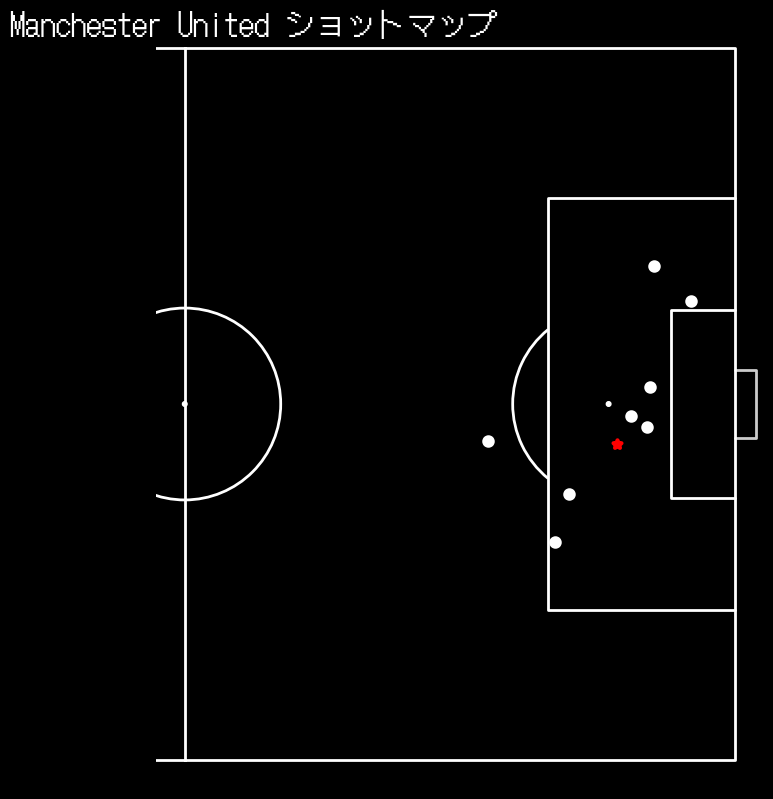

In [7]:
shotmap_gen(game)

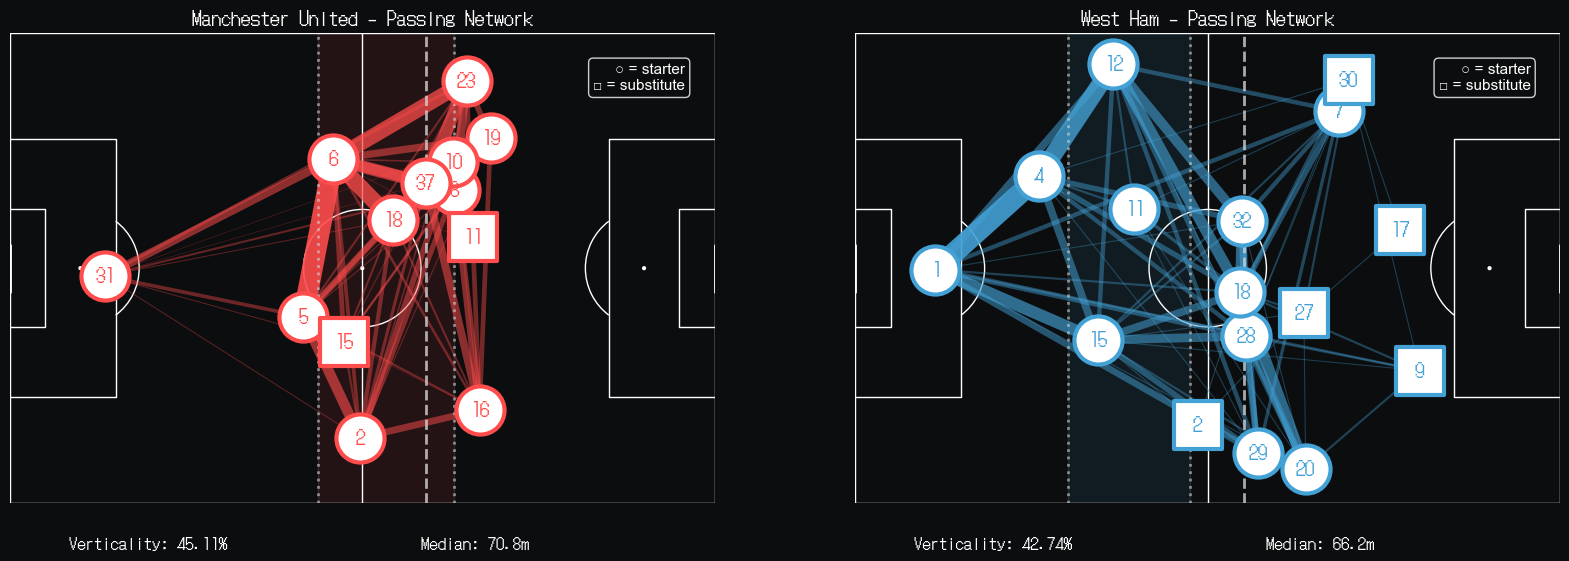

In [40]:
import warnings

warnings.filterwarnings('ignore')

pass_df = game[['team', 'player', 'player_id', 'minute', 'type', 'outcome_type', 'second', 'x', 'y', 'end_x', 'end_y']]

opposition = find_opp(pass_df)
mutd_df = pass_df[pass_df['team'] == 'Man Utd']
opposition_df = pass_df[pass_df['team'] == opposition]

mutd_pass_df = splitter(mutd_df)
opposition_pass_df = splitter(opposition_df)

mutd_pass_comb = pass_comb(mutd_pass_df)
opposition_pass_comb = pass_comb(opposition_pass_df)

mutd_avg_location = enhance_position(mutd_pass_df, game_id, mutd_pass_comb)
opposition_avg_location = enhance_position(opposition_pass_df, game_id, opposition_pass_comb)

mutd_team_metric = team_metric(mutd_pass_df, mutd_avg_location, game_id)
opposition_team_metric = team_metric(opposition_pass_df, opposition_avg_location, game_id)

background_color = '#0C0D0E'
home_color = '#FF4C4C'
away_color = '#43A1D5'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.patch.set_facecolor(background_color)

plotter(ax1, mutd_df, mutd_avg_location, mutd_pass_comb, mutd_team_metric,
'Manchester United', color=home_color, bg_color=background_color)

plotter(ax2, opposition_df, opposition_avg_location, opposition_pass_comb, opposition_team_metric,
opposition, color=away_color, bg_color=background_color)

In [64]:
casemiro_pass  = pass_df[pass_df['player'] == 'Casemiro']

In [61]:
casemiro_pass

team  \
league             season game                                             
ENG-Premier League 2526   2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   
...                                                                  ...   
                          2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   
                          2026-02-10 West Ham-Manchester United  Man Utd   

                                                                    player  \
league             season game                                               
ENG-Premier League 2526   2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
...                                                                    ...   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   
                          2026-02-10 West Ham-Manchester United  Luke Shaw   

                                                                 player_id  \
league             season game                                               
ENG-Premier League 2526   2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   
...                                                                    ...   
                          2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   
                          2026-02-10 West Ham-Manchester United   118244.0   

                                                                 minute  \
league             season game                                            
ENG-Premier League 2526   2026-02-10 West Ham-Manchester United       0   
                          2026-02-10 West Ham-Manchester United       0   
                          2026-02-10 West Ham-Manchester United       1   
                          2026-02-10 West Ham-Manchester United       1   
                          2026-02-10 West Ham-Manchester United       1   
...                                                                 ...   
                          2026-02-10 West Ham-Manchester United      90   
                          2026-02-10 West Ham-Manchester United      90   
                          2026-02-10 West Ham-Manchester United      91   
                          2026-02-10 West Ham-Manchester United      94   
                          2026-02-10 West Ham-Manchester United      94   

                                                                   type  

In [65]:
def pass_plot (ax, df1,df2, bg_color):
    player = df1['player'].head(1)
    pitch.draw(ax = ax)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.set_facecolor(bg_color)



    for _, row in df1.iterrows():
        color = 'red'
        pitch.lines(row['x']*1.2, row['y']*0.8,row['end_x']*1.2, row['end_y']*0.8, color = color, linewidth=8, transparent=True, comet=True,ax=ax, zorder=1)

    for _, row in df2.iterrows():
        color = 'purple'
        pitch.lines(row['x']*1.2, row['y']*0.8,row['end_x']*1.2, row['end_y']*0.8, color = color,linewidth=8,transparent=True, comet=True,ax=ax, zorder=1)

    ax.axis('equal')
    ax.set_title(f"{player} - Passes", font=font, fontsize=14, color='white')

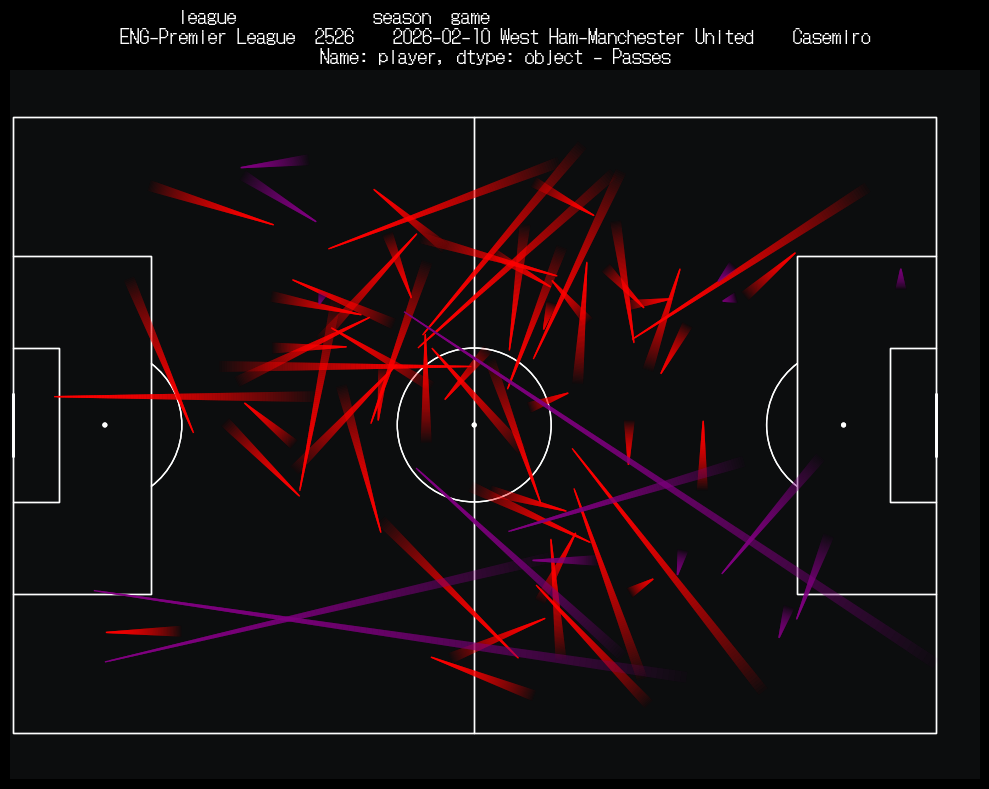

In [66]:
pitch = Pitch(pitch_type='statsbomb',line_color = 'white', linewidth=1)
fig, ax = pitch.draw(figsize=(10,8))

casemiro_success = casemiro_pass[casemiro_pass['outcome_type'] == 'Successful']
casemiro_fail = casemiro_pass[casemiro_pass['outcome_type'] == 'Unsuccessful']

pass_plot(ax, casemiro_success, casemiro_fail,bg_color= '#0C0D0E')